In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
import time
import csv
from datetime import timedelta
%matplotlib inline

In [2]:
# Read trips text files into pandas dataframe
df1 = pd.read_csv("rt_trips_full.csv", sep=',')
df1 = df1.drop(['datasource', 'basin', 'tenderlot', 'suppressed', 'justificationid', 'lastupdate', 'note'], axis=1)
df1.shape

(2041415, 9)

In [3]:
df1.head(5)

,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep
0,09-FEB-16 00:00:00,2824642,145,145_105,2,45668,40800,45375.0,40782.0
1,09-FEB-16 00:00:00,2826717,9,9_7,2,65553,60600,66258.0,60582.0
2,09-FEB-16 00:00:00,2826730,54A,54A_12,2,65951,62100,66053.0,62078.0
3,09-FEB-16 00:00:00,2826743,7,7_51,1,54763,50400,54854.0,50383.0
4,09-FEB-16 00:00:00,2812908,39,39_20,1,27375,22920,27318.0,22931.0


In [6]:
# Read weather data into dataframe

URI="localhost"
PORT="5433"
DB="jetaDb"
PORT="5433"
USER="postgres"
PASSWORD='00001234'

engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(USER,PASSWORD,URI,PORT,DB), echo=True)

In [7]:
sql = "SELECT * FROM main_weather"

weather = pd.read_sql(sql, engine)

2018-07-17 10:06:30,568 INFO sqlalchemy.engine.base.Engine select version()
2018-07-17 10:06:30,570 INFO sqlalchemy.engine.base.Engine {}
2018-07-17 10:06:30,621 INFO sqlalchemy.engine.base.Engine select current_schema()
2018-07-17 10:06:30,626 INFO sqlalchemy.engine.base.Engine {}
2018-07-17 10:06:30,699 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-07-17 10:06:30,704 INFO sqlalchemy.engine.base.Engine {}
2018-07-17 10:06:30,731 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-07-17 10:06:30,732 INFO sqlalchemy.engine.base.Engine {}
2018-07-17 10:06:30,796 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2018-07-17 10:06:30,805 INFO sqlalchemy.engine.base.Engine {}
2018-07-17 10:06:30,936 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

In [8]:
weather_sort = weather.sort_values('rain',ascending=True)
weather_sort.head(5)

,id,date,time,irain,rain,itemp,temp,iwetb,wetb,dewpt,vappr,rhum,msl
11195,11196,4/11/2017,11:00,-1,,0,10.7,0,7.9,4.6,8.5,65,1028.7
11194,11195,4/11/2017,10:00,-1,,0,11,0,8.4,5.3,8.9,68,1028.8
0,1,1/1/2016,0:00,0,0,0,1.2,0,0.7,-0.2,6,90,1016.2
13494,13495,7/16/2017,6:00,0,0,0,13.7,0,13.3,12.9,14.9,95,1022.5
13489,13490,7/16/2017,1:00,0,0,0,16.9,0,16.1,15.6,17.7,92,1019.6


In [9]:
# Drop weather rows with no rain data
weather = weather_sort.drop([11194, 11195])
weather.dtypes

id        int64
date     object
time     object
irain     int64
rain     object
itemp     int64
temp     object
iwetb     int64
wetb     object
dewpt    object
vappr    object
rhum     object
msl      object
dtype: object

In [10]:
weather['rain'] = weather['rain'].astype(float)

## How many time rows in "trips" have NaN values?

In [11]:
null_columns = df1.columns[df1.isnull().any()]
df1[null_columns].isnull().sum()

actualtime_arr    153027
actualtime_dep    190288
dtype: int64

In [12]:
df2 = df1[df1.actualtime_arr.notnull()]
df3 = df2[df2.actualtime_dep.notnull()]
df3.shape

(1717640, 9)

In [13]:
null_columns = df3.columns[df3.isnull().any()]
df3[null_columns].isnull().sum()

Series([], dtype: float64)

## Create journey duration time column

In [14]:
df3['journey_time'] = (df3['actualtime_arr'] - df3['actualtime_dep']).apply(lambda x: x if (x >= 0 and x != np.nan) else 0)
df3.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,journey_time
0,09-FEB-16 00:00:00,2824642,145,145_105,2,45668,40800,45375.0,40782.0,4593.0
1,09-FEB-16 00:00:00,2826717,9,9_7,2,65553,60600,66258.0,60582.0,5676.0
2,09-FEB-16 00:00:00,2826730,54A,54A_12,2,65951,62100,66053.0,62078.0,3975.0
3,09-FEB-16 00:00:00,2826743,7,7_51,1,54763,50400,54854.0,50383.0,4471.0
4,09-FEB-16 00:00:00,2812908,39,39_20,1,27375,22920,27318.0,22931.0,4387.0


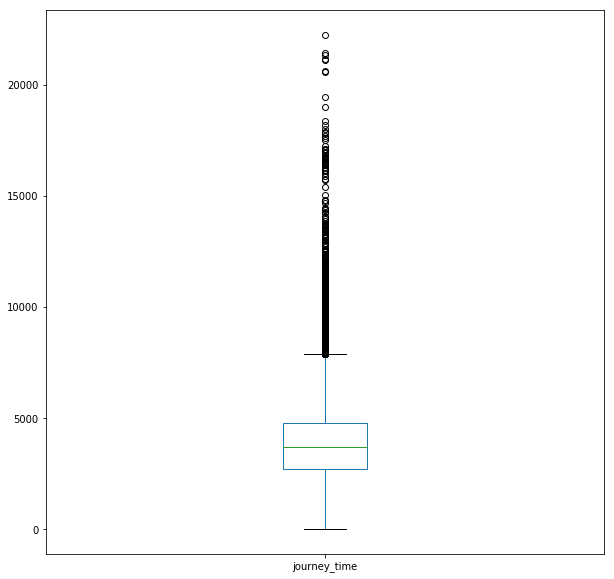

In [149]:
f = df3['journey_time'].plot(kind='box', figsize=(10,10))
plt.show()

In [153]:
# We only want journey times that are positive and remove outliers
positive = df3['journey_time'] > 0
df3 = df3[positive]
outliers = df3['journey_time'] < 19000
df3 = df3[outliers]
df3.shape

(1717452, 10)

## Change time to human readable

In [16]:
def changetime(x):
    return time.strftime("%H:%M:%S", time.localtime(x))

In [17]:
df3['actualtime_arr'] = df3['actualtime_arr'].apply(changetime)

In [18]:
df3['plannedtime_arr'] = df3['plannedtime_arr'].apply(changetime)

In [19]:
df3['actualtime_dep'] = df3['actualtime_dep'].apply(changetime)

In [20]:
df3['plannedtime_dep'] = df3['plannedtime_dep'].apply(changetime)

In [21]:
df3.head(5)

,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,journey_time
0,09-FEB-16 00:00:00,2824642,145,145_105,2,13:41:08,12:20:00,13:36:15,12:19:42,4593.0
1,09-FEB-16 00:00:00,2826717,9,9_7,2,19:12:33,17:50:00,19:24:18,17:49:42,5676.0
2,09-FEB-16 00:00:00,2826730,54A,54A_12,2,19:19:11,18:15:00,19:20:53,18:14:38,3975.0
3,09-FEB-16 00:00:00,2826743,7,7_51,1,16:12:43,15:00:00,16:14:14,14:59:43,4471.0
4,09-FEB-16 00:00:00,2812908,39,39_20,1,08:36:15,07:22:00,08:35:18,07:22:11,4387.0


In [22]:
df3.dtypes

dayofservice        object
tripid               int64
lineid              object
routeid             object
direction            int64
plannedtime_arr     object
plannedtime_dep     object
actualtime_arr      object
actualtime_dep      object
journey_time       float64
dtype: object

In [23]:
df3['lineid'] = df3['lineid'].astype(str)

# Only look at the 46A (option)

In [24]:
# Uncomment out the 46A line to shoose a single route
# FortySixA = df3.loc[df3['lineid'] == "46A"]
FortySixA = df3
FortySixA.head(5)

,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,journey_time
0,09-FEB-16 00:00:00,2824642,145,145_105,2,13:41:08,12:20:00,13:36:15,12:19:42,4593.0
1,09-FEB-16 00:00:00,2826717,9,9_7,2,19:12:33,17:50:00,19:24:18,17:49:42,5676.0
2,09-FEB-16 00:00:00,2826730,54A,54A_12,2,19:19:11,18:15:00,19:20:53,18:14:38,3975.0
3,09-FEB-16 00:00:00,2826743,7,7_51,1,16:12:43,15:00:00,16:14:14,14:59:43,4471.0
4,09-FEB-16 00:00:00,2812908,39,39_20,1,08:36:15,07:22:00,08:35:18,07:22:11,4387.0


In [25]:
FortySixA['dayofservice'] = pd.to_datetime(FortySixA['dayofservice'])

## Create merged dataframe of weather and trips data

In [26]:
FortySixArain = df3.loc[df3['lineid'] == "46A"]
FortySixArain['dayofservice'] = pd.to_datetime(FortySixArain['dayofservice'])
FortySixArain['actualtime_dep'] = pd.to_datetime(FortySixArain['actualtime_dep'])
FortySixArain['hour'] = FortySixArain['actualtime_dep'].dt.round('H').dt.hour
FortySixArain.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,journey_time,hour
103,2016-02-09,2815441,46A,46A_74,1,18:17:37,17:00:00,18:23:07,2018-07-17 17:00:39,4948.0,17
151,2016-02-09,2822666,46A,46A_67,2,14:48:07,13:28:00,15:04:06,2018-07-17 13:27:28,5798.0,13
154,2016-02-09,2822373,46A,46A_74,1,10:19:59,08:52:00,10:25:31,2018-07-17 08:52:03,5608.0,9
182,2016-04-08,3011257,46A,46A_67,2,12:57:29,11:36:00,13:15:38,2018-07-17 11:34:41,6057.0,12
199,2016-04-08,3010331,46A,46A_74,1,22:34:55,21:40:00,22:32:45,2018-07-17 21:39:35,3190.0,22


In [27]:
weather['date'] = pd.to_datetime(weather['date'],infer_datetime_format=True)
weather['time'] = pd.to_datetime(weather['time'],infer_datetime_format=True)
weather['hour'] = weather['time'].dt.hour

In [28]:
weather.head(5)

,id,date,time,irain,rain,itemp,temp,iwetb,wetb,dewpt,vappr,rhum,msl,hour
0,1,2016-01-01,2018-07-17 00:00:00,0,0.0,0,1.2,0,0.7,-0.2,6,90,1016.2,0
13494,13495,2017-07-16,2018-07-17 06:00:00,0,0.0,0,13.7,0,13.3,12.9,14.9,95,1022.5,6
13489,13490,2017-07-16,2018-07-17 01:00:00,0,0.0,0,16.9,0,16.1,15.6,17.7,92,1019.6,1
13488,13489,2017-07-16,2018-07-17 00:00:00,0,0.0,0,17.1,0,16.1,15.3,17.4,89,1019.2,0
13487,13488,2017-07-15,2018-07-17 23:00:00,0,0.0,0,17.5,0,16.4,15.6,17.8,89,1019.1,23


In [29]:
weather_46a_merged = FortySixArain.merge(weather,left_on=['dayofservice','hour'],right_on=['date','hour'],how='left')
weather_46a_merged.shape

(64176, 24)

In [30]:
# FortySixA['duration'] = pd.to_datetime(FortySixA['actualtime_arr']) - pd.to_datetime(FortySixA['actualtime_dep'])
# FortySixA['duration'] = FortySixA['duration'].astype('timedelta64[m]')

In [31]:
# avgs.set_value(0, 'day', 'monday')
# avgs.set_value(0, 'time', '09:00')
# avgs.head(5)

In [32]:
# check = FortySixA.loc[FortySixA['tripid'] == 2813970]
# check.head(5)

## Only look at normal Monday's

In [33]:
monday1 = FortySixA['dayofservice'] == '2016-02-01'
monday1 = FortySixA[monday1]

In [34]:
monday2 = FortySixA['dayofservice'] == '2016-02-08'
monday2 = FortySixA[monday2]

In [35]:
monday3 = FortySixA['dayofservice'] == '2016-02-22'
monday3 = FortySixA[monday3]

In [36]:
monday4 = FortySixA['dayofservice'] == '2016-03-07'
monday4 = FortySixA[monday4]

In [37]:
monday5 = FortySixA['dayofservice'] == '2016-03-14'
monday5 = FortySixA[monday5]

In [38]:
monday6 = FortySixA['dayofservice'] == '2016-04-04'
monday6 = FortySixA[monday6]

In [39]:
monday7 = FortySixA['dayofservice'] == '2016-04-18'
monday7 = FortySixA[monday7]

In [40]:
monday8 = FortySixA['dayofservice'] == '2016-04-25'
monday8 = FortySixA[monday8]

In [41]:
monday9 = FortySixA['dayofservice'] == '2016-05-09'
monday9 = FortySixA[monday9]

In [42]:
monday10 = FortySixA['dayofservice'] == '2016-05-16'
monday10 = FortySixA[monday10]

In [43]:
monday11 = FortySixA['dayofservice'] == '2016-05-30'
monday11 = FortySixA[monday11]

In [44]:
monday12 = FortySixA['dayofservice'] == '2016-06-13'
monday12 = FortySixA[monday12]

In [45]:
monday13 = FortySixA['dayofservice'] == '2016-06-20'
monday13 = FortySixA[monday13]

In [46]:
monday14 = FortySixA['dayofservice'] == '2016-06-27'
monday14 = FortySixA[monday14]

In [47]:
monday15 = FortySixA['dayofservice'] == '2017-02-06'
monday15 = FortySixA[monday15]

In [48]:
monday16 = FortySixA['dayofservice'] == '2016-02-13'
monday16 = FortySixA[monday16]

In [49]:
monday17 = FortySixA['dayofservice'] == '2016-02-27'
monday17 = FortySixA[monday17]

In [50]:
monday18 = FortySixA['dayofservice'] == '2016-03-06'
monday18 = FortySixA[monday18]

In [51]:
monday19 = FortySixA['dayofservice'] == '2016-03-13'
monday19 = FortySixA[monday19]

In [52]:
monday20 = FortySixA['dayofservice'] == '2016-03-20'
monday20 = FortySixA[monday20]

In [53]:
monday21 = FortySixA['dayofservice'] == '2016-04-17'
monday21 = FortySixA[monday21]

In [54]:
monday22 = FortySixA['dayofservice'] == '2016-04-24'
monday22 = FortySixA[monday22]

In [55]:
monday23 = FortySixA['dayofservice'] == '2016-05-08'
monday23 = FortySixA[monday23]

In [56]:
monday24 = FortySixA['dayofservice'] == '2016-05-15'
monday24 = FortySixA[monday24]

In [57]:
monday25 = FortySixA['dayofservice'] == '2016-05-22'
monday25 = FortySixA[monday25]

In [58]:
monday26 = FortySixA['dayofservice'] == '2016-06-12'
monday26 = FortySixA[monday26]

In [59]:
monday27 = FortySixA['dayofservice'] == '2016-06-19'
monday27 = FortySixA[monday27]

In [60]:
monday28 = FortySixA['dayofservice'] == '2016-06-26'
monday28 = FortySixA[monday28]

In [61]:
normal_mondays = pd.concat([monday1, monday5, monday9, monday12, monday17, monday25, monday28])
#normal_mondays = pd.concat([monday1, monday2, monday3,  monday4, monday5, monday6, monday7, monday8, monday9, monday10, monday11, monday12, monday13, monday14, monday15, monday16, monday17, monday18, monday19, monday20, monday21, monday22, monday23, monday24, monday25, monday26, monday27, monday28])

## Bank holiday Monday's

In [62]:
bhmonday1 = FortySixA['dayofservice'] == '2016-03-28'
bhmonday1 = FortySixA[bhmonday1]

In [63]:
bhmonday2 = FortySixA['dayofservice'] == '2016-05-02'
bhmonday2 = FortySixA[bhmonday2]

In [64]:
bhmonday3 = FortySixA['dayofservice'] == '2016-06-06'
bhmonday3 = FortySixA[bhmonday3]

In [65]:
bhmonday4 = FortySixA['dayofservice'] == '2017-04-17'
bhmonday4 = FortySixA[bhmonday4]

In [66]:
bhmonday5 = FortySixA['dayofservice'] == '2017-05-01'
bhmonday5 = FortySixA[bhmonday5]

In [67]:
bhmonday6 = FortySixA['dayofservice'] == '2017-06-05'
bhmonday6 = FortySixA[bhmonday6]

In [68]:
bh_mondays = pd.concat([bhmonday1, bhmonday2, bhmonday3,  bhmonday4, bhmonday5, bhmonday6])

# Sunday's

In [69]:
sunday1 = FortySixA['dayofservice'] == '2016-02-07'
sunday1 = FortySixA[sunday1]

In [70]:
sunday2 = FortySixA['dayofservice'] == '2016-02-28'
sunday2 = FortySixA[sunday2]

In [71]:
sunday3 = FortySixA['dayofservice'] == '2016-04-03'
sunday3 = FortySixA[sunday3]

In [72]:
sunday4 = FortySixA['dayofservice'] == '2016-04-24'
sunday4 = FortySixA[sunday4]

In [73]:
sunday5 = FortySixA['dayofservice'] == '2017-02-05'
sunday5 = FortySixA[sunday5]

In [74]:
sunday6 = FortySixA['dayofservice'] == '2017-04-23'
sunday6 = FortySixA[sunday6]

In [75]:
sundays = pd.concat([sunday1, sunday2, sunday3, sunday4, sunday5, sunday6])

## Half term

In [76]:
ht1 = FortySixA['dayofservice'] == '2016-02-15'
ht1 = FortySixA[ht1]

In [77]:
ht2 = FortySixA['dayofservice'] == '2016-02-16'
ht2 = FortySixA[ht2]

In [78]:
ht3 = FortySixA['dayofservice'] == '2016-02-17'
ht3 = FortySixA[ht3]

In [79]:
ht4 = FortySixA['dayofservice'] == '2016-02-18'
ht4 = FortySixA[ht4]

In [80]:
ht5 = FortySixA['dayofservice'] == '2016-02-19'
ht5 = FortySixA[ht5]

In [81]:
ht6 = FortySixA['dayofservice'] == '2017-02-20'
ht6 = FortySixA[ht6]

In [82]:
ht7 = FortySixA['dayofservice'] == '2017-02-21'
ht7 = FortySixA[ht7]

In [83]:
ht8 = FortySixA['dayofservice'] == '2017-02-22'
ht8 = FortySixA[ht8]

In [84]:
ht9 = FortySixA['dayofservice'] == '2017-02-23'
ht9 = FortySixA[ht9]

In [85]:
ht10 = FortySixA['dayofservice'] == '2017-02-24'
ht10 = FortySixA[ht10]

In [86]:
half_term = pd.concat([ht1, ht2, ht3, ht4, ht5, ht6, ht7,ht8, ht9, ht10])

## Normal school week 

In [87]:
sw1 = FortySixA['dayofservice'] == '2016-02-01'
sw1 = FortySixA[sw1]

In [88]:
sw2 = FortySixA['dayofservice'] == '2016-02-02'
sw2 = FortySixA[sw2]

In [89]:
sw3 = FortySixA['dayofservice'] == '2016-02-03'
sw3 = FortySixA[sw3]

In [90]:
sw4 = FortySixA['dayofservice'] == '2016-02-04'
sw4 = FortySixA[sw4]

In [91]:
sw5 = FortySixA['dayofservice'] == '2016-02-05'
sw5 = FortySixA[sw5]

In [92]:
sw6 = FortySixA['dayofservice'] == '2017-02-06'
sw6 = FortySixA[sw6]

In [93]:
sw7 = FortySixA['dayofservice'] == '2017-02-07'
sw7 = FortySixA[sw7]

In [94]:
sw8 = FortySixA['dayofservice'] == '2017-02-08'
sw8 = FortySixA[sw8]

In [95]:
sw9 = FortySixA['dayofservice'] == '2017-02-09'
sw9 = FortySixA[sw9]

In [96]:
sw10 = FortySixA['dayofservice'] == '2017-02-10'
sw10 = FortySixA[sw10]

In [97]:
school_week = pd.concat([sw1, sw2, sw3, sw4, sw5, sw6, sw7, sw8, sw9, sw10])

In [98]:
# normal_mondays.actualtime_dep = pd.to_datetime(normal_mondays.actualtime_dep,format= '%H:%M:%S').dt.time

## Create dataframe for plot data

In [99]:
avgs = pd.DataFrame(columns=['time', 'avg_duration_norm','avg_duration_bh','avg_duration_sun', 'half_term', 'school_week', 'rainy', 'dry'])

In [100]:
avgs['time'] = pd.to_datetime(avgs['time'])
avgs['avg_duration_norm'] = avgs.avg_duration_norm.astype(float)
avgs['avg_duration_bh'] = avgs.avg_duration_norm.astype(float)
avgs['avg_duration_sun'] = avgs.avg_duration_norm.astype(float)
avgs['half_term'] = avgs.avg_duration_norm.astype(float)
avgs['school_week'] = avgs.avg_duration_norm.astype(float)
avgs['rainy'] = avgs.avg_duration_norm.astype(float)
avgs['dry'] = avgs.avg_duration_norm.astype(float)
avgs.head(5)

,time,avg_duration_norm,avg_duration_bh,avg_duration_sun,half_term,school_week,rainy,dry


## Fill in plot data with averages from (half-hourly) timeframes across various days

In [101]:
times = ['06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00']
i = 0
while i <= len(times):
    if i == len(times) - 1:
        break
    else:
        index = pd.DatetimeIndex(normal_mondays['actualtime_dep'])
        look = normal_mondays.iloc[index.indexer_between_time(times[i],times[i+1])]
        mean = look['journey_time'].median()
        avgs.set_value(i, 'time', times[i])
        avgs.set_value(i, 'avg_duration_norm', mean)
    i += 1

    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [102]:
times = ['06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00']
i = 0
while i <= len(times):
    if i == len(times) - 1:
        break
    else:
        index = pd.DatetimeIndex(bh_mondays['actualtime_dep'])
        look = bh_mondays.iloc[index.indexer_between_time(times[i],times[i+1])]
        mean = look['journey_time'].median()
        avgs.set_value(i, 'avg_duration_bh', mean)
    i += 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [103]:
times = ['06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00']
i = 0
while i <= len(times):
    if i == len(times) - 1:
        break
    else:
        index = pd.DatetimeIndex(sundays['actualtime_dep'])
        look = sundays.iloc[index.indexer_between_time(times[i],times[i+1])]
        mean = look['journey_time'].median()
        avgs.set_value(i, 'avg_duration_sun', mean)
    i += 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [104]:
times = ['06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00']
i = 0
while i <= len(times):
    if i == len(times) - 1:
        break
    else:
        index = pd.DatetimeIndex(half_term['actualtime_dep'])
        look = half_term.iloc[index.indexer_between_time(times[i],times[i+1])]
        mean = look['journey_time'].median()
        avgs.set_value(i, 'half_term', mean)
    i += 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [105]:
times = ['06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00']
i = 0
while i <= len(times):
    if i == len(times) - 1:
        break
    else:
        index = pd.DatetimeIndex(school_week['actualtime_dep'])
        look = school_week.iloc[index.indexer_between_time(times[i],times[i+1])]
        mean = look['journey_time'].median()
        avgs.set_value(i, 'school_week', mean)
    i += 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [106]:
# avgs.to_csv('averages.csv', index=False)

In [107]:
# avgs['time'] = pd.Series([val.time() for val in avgs['time']])

# Plots

## Normal Mondays vs Bank Holiday Mondays

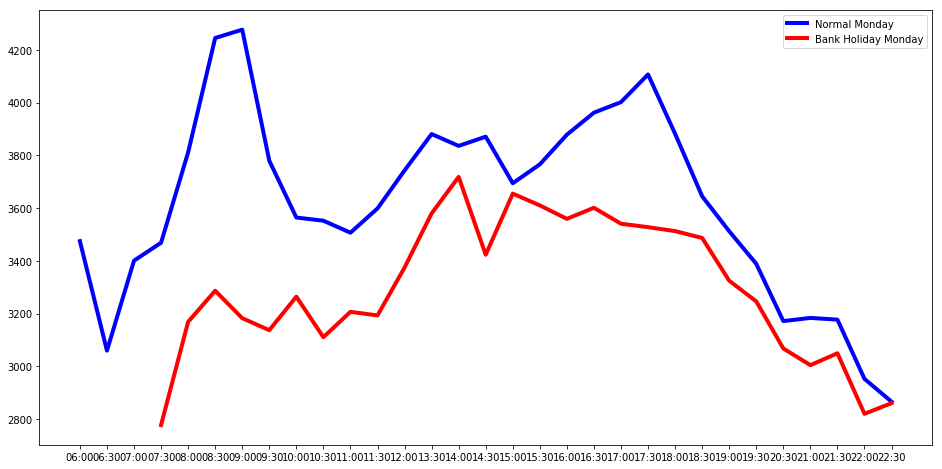

In [108]:
plt.figure(figsize=(16,8))
plt.plot('time', 'avg_duration_norm', data=avgs, color='blue', linewidth=4, label="Normal Monday")
plt.plot('time', 'avg_duration_bh', data=avgs, color='red', linewidth=4, label="Bank Holiday Monday")
plt.legend()

# Sundays vs Bank Holiday Mondays

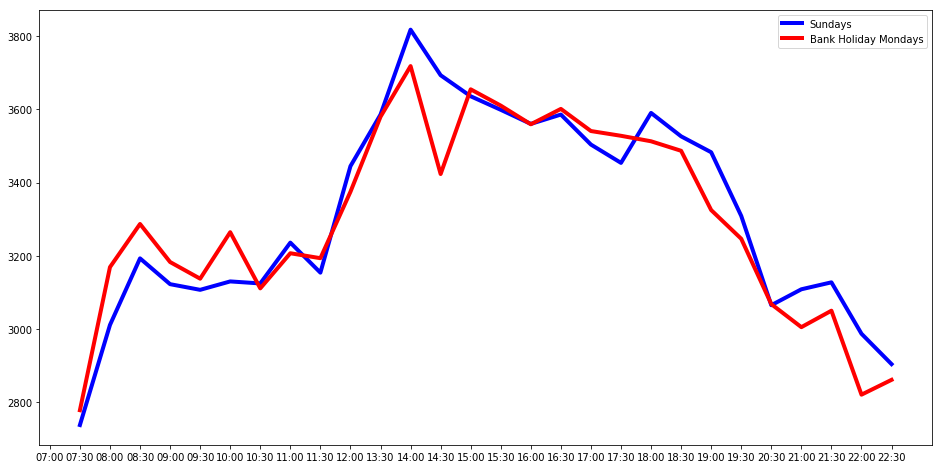

In [109]:
plt.figure(figsize=(16,8))
plt.plot('time', 'avg_duration_sun', data=avgs, color='blue', linewidth=4, label="Sundays")
plt.plot('time', 'avg_duration_bh', data=avgs, color='red', linewidth=4, label="Bank Holiday Mondays")
plt.legend()

## Half term vs normal school week 

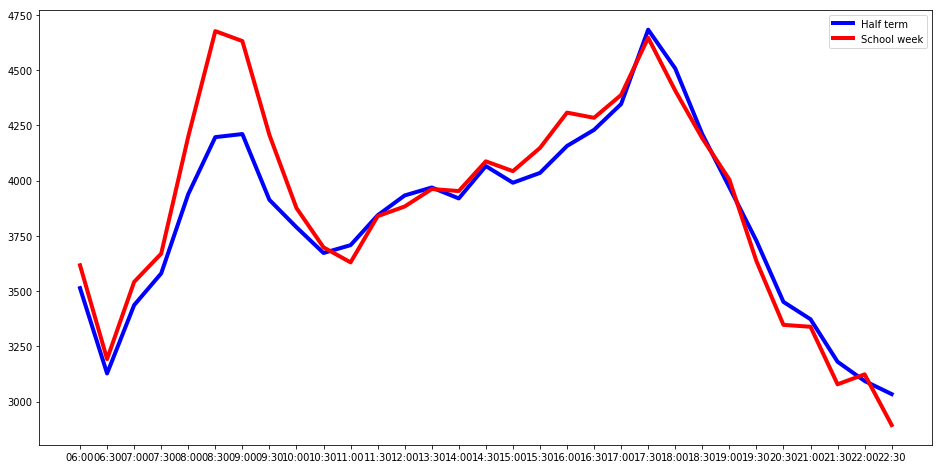

In [110]:
plt.figure(figsize=(16,8))
plt.plot('time', 'half_term', data=avgs, color='blue', linewidth=4, label="Half term")
plt.plot('time', 'school_week', data=avgs, color='red', linewidth=4, label="School week")
plt.legend()

# Look into rain vs dry data

In [111]:
weather_46a_merged['weekday'] = weather_46a_merged['dayofservice'].dt.weekday_name
# weather_46a_merged['actualtime_dep'] = pd.Series([val.time() for val in weather_46a_merged['actualtime_dep']])

In [112]:
weather_46a_merged['rain'] = weather_46a_merged['rain'].astype(float)
weather_46a_merged.head(5)

,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,journey_time,...,rain,itemp,temp,iwetb,wetb,dewpt,vappr,rhum,msl,weekday
0,2016-02-09,2815441,46A,46A_74,1,18:17:37,17:00:00,18:23:07,2018-07-17 17:00:39,4948.0,...,0.0,0.0,4.2,0.0,4.2,4.2,8.2,99,985.3,Tuesday
1,2016-02-09,2822666,46A,46A_67,2,14:48:07,13:28:00,15:04:06,2018-07-17 13:27:28,5798.0,...,0.4,0.0,3.1,0.0,3,2.8,7.5,98,982.8,Tuesday
2,2016-02-09,2822373,46A,46A_74,1,10:19:59,08:52:00,10:25:31,2018-07-17 08:52:03,5608.0,...,0.0,0.0,2.5,0.0,2,1.3,6.7,92,983.7,Tuesday
3,2016-04-08,3011257,46A,46A_67,2,12:57:29,11:36:00,13:15:38,2018-07-17 11:34:41,6057.0,...,0.2,0.0,7.5,0.0,6.6,5.5,9,87,1009.3,Friday
4,2016-04-08,3010331,46A,46A_74,1,22:34:55,21:40:00,22:32:45,2018-07-17 21:39:35,3190.0,...,0.0,0.0,3.9,0.0,3.5,2.8,7.5,92,1002.9,Friday


In [156]:
rainy = weather_46a_merged['rain'] > 0.5
heavy_rain = weather_46a_merged[rainy]
many_hours = heavy_rain.groupby('dayofservice').count()
# Days with 40+ rows on rainy data
many_hours = many_hours['tripid'] > 50
many_hours2 = many_hours[many_hours]
many_hours2.head(100)

dayofservice
2016-04-11    True
2017-03-22    True
2017-05-27    True
Name: tripid, dtype: bool

In [114]:
hv1 = heavy_rain['dayofservice'] == '2016-02-16'
hv1 = heavy_rain[hv1]

In [115]:
hv2 = heavy_rain['dayofservice'] == '2016-02-29'
hv2 = heavy_rain[hv2]

In [116]:
hv3 = heavy_rain['dayofservice'] == '2016-03-04'
hv3 = heavy_rain[hv3]

In [117]:
hv4 = heavy_rain['dayofservice'] == '2016-04-11'
hv4 = heavy_rain[hv4]

In [118]:
hv5 = heavy_rain['dayofservice'] == '2016-05-21'
hv5 = heavy_rain[hv5]

In [119]:
hv6 = heavy_rain['dayofservice'] == '2016-06-24'
hv6 = heavy_rain[hv6]

In [120]:
hv6 = heavy_rain['dayofservice'] == '2017-02-11'
hv6 = heavy_rain[hv6]

In [121]:
hv6 = heavy_rain['dayofservice'] == '2017-02-22'
hv6 = heavy_rain[hv6]

In [122]:
hv7 = heavy_rain['dayofservice'] == '2017-02-28'
hv7 = heavy_rain[hv7]

In [123]:
hv8 = heavy_rain['dayofservice'] == '2017-03-03'
hv8 = heavy_rain[hv8]

In [124]:
hv9 = heavy_rain['dayofservice'] == '2017-05-27'
hv9 = heavy_rain[hv9]

In [125]:
hv10 = heavy_rain['dayofservice'] == '2017-06-05'
hv10 = heavy_rain[hv10]

In [126]:
rain_avg = pd.concat([hv1, hv2, hv3, hv4, hv5, hv6, hv7, hv8, hv9, hv10])

In [127]:
dry = weather_46a_merged['rain'] == 0
dry = weather_46a_merged[dry]
dry.head(5)

,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,journey_time,...,rain,itemp,temp,iwetb,wetb,dewpt,vappr,rhum,msl,weekday
0,2016-02-09,2815441,46A,46A_74,1,18:17:37,17:00:00,18:23:07,2018-07-17 17:00:39,4948.0,...,0.0,0.0,4.2,0.0,4.2,4.2,8.2,99,985.3,Tuesday
2,2016-02-09,2822373,46A,46A_74,1,10:19:59,08:52:00,10:25:31,2018-07-17 08:52:03,5608.0,...,0.0,0.0,2.5,0.0,2,1.3,6.7,92,983.7,Tuesday
4,2016-04-08,3010331,46A,46A_74,1,22:34:55,21:40:00,22:32:45,2018-07-17 21:39:35,3190.0,...,0.0,0.0,3.9,0.0,3.5,2.8,7.5,92,1002.9,Friday
7,2016-04-02,2911801,46A,46A_67,2,09:29:21,08:30:00,09:38:05,2018-07-17 08:32:11,3954.0,...,0.0,0.0,8.7,0.0,8.6,8.6,11.2,99,1008,Saturday
20,2016-04-07,3012113,46A,46A_74,1,16:18:26,15:00:00,16:23:44,2018-07-17 15:00:10,5014.0,...,0.0,0.0,12.5,0.0,9.2,5.4,9,61,1012.8,Thursday


In [128]:
dry1 = dry['dayofservice'] == '2016-02-09'
dry1 = dry[dry1]

In [129]:
dry2 = dry['dayofservice'] == '2016-04-08'
dry2 = dry[dry2]

In [130]:
dry3 = dry['dayofservice'] == '2016-04-02'
dry3 = dry[dry3]

In [131]:
dry4 = dry['dayofservice'] == '2016-03-05'
dry4 = dry[dry4]

In [132]:
dry5 = dry['dayofservice'] == '2016-05-20'
dry5 = dry[dry5]

In [133]:
dry6 = dry['dayofservice'] == '2017-05-03'
dry6 = dry[dry6]

In [134]:
dry6 = dry['dayofservice'] == '2017-06-27'
dry6 = dry[dry6]

In [135]:
dry7 = dry['dayofservice'] == '2017-03-14'
dry7 = dry[dry7]

In [136]:
dry8 = dry['dayofservice'] == '2017-04-21'
dry8 = dry[dry8]

In [137]:
dry9 = dry['dayofservice'] == '2017-02-08'
dry9 = dry[dry9]

In [138]:
dry10 = dry['dayofservice'] == '2017-05-26'
dry10 = dry[dry10]

In [139]:
dry_avg = pd.concat([dry1, dry2, dry3, dry4, dry5, dry6, dry7, dry8, dry9, dry10])

In [140]:
# hv_mon = heavy_rain['dayofservice'] == '2016-02-29'
# hv_mon = heavy_rain[hv_mon]
# hv_mon_sort = hv_mon.sort_values('actualtime_dep',ascending=True)
# hv_mon_sort.head(5)

In [141]:
times = ['06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00']
i = 0
while i <= len(times):
    if i == len(times) - 1:
        break
    else:
        index = pd.DatetimeIndex(rain_avg['actualtime_dep'])
        look = rain_avg.iloc[index.indexer_between_time(times[i],times[i+1])]
        mean = look['journey_time'].median()
        avgs.set_value(i, 'rainy', mean)
    i += 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [142]:
times = ['06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00']
i = 0
while i <= len(times):
    if i == len(times) - 1:
        break
    else:
        index = pd.DatetimeIndex(dry_avg['actualtime_dep'])
        look = dry_avg.iloc[index.indexer_between_time(times[i],times[i+1])]
        mean = look['journey_time'].median()
        avgs.set_value(i, 'dry', mean)
    i += 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


## Rainy days vs dry days

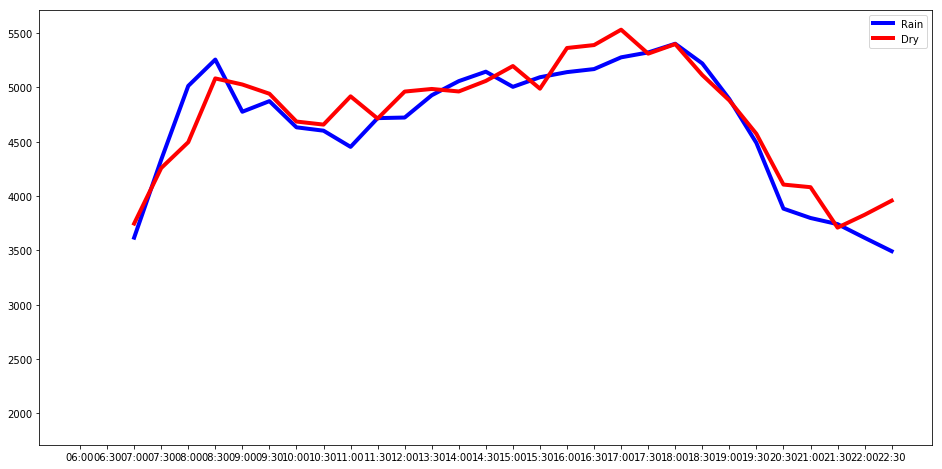

In [143]:
plt.figure(figsize=(16,8))
plt.plot('time', 'rainy', data=avgs, color='blue', linewidth=4, label="Rain")
plt.plot('time', 'dry', data=avgs, color='red', linewidth=4, label="Dry")
plt.legend()

# Conclusions

The morning peak during school holidays has a significant difference which our model should take into consideration. The difference in median values over the morning rush hours is:

In [144]:
school_morn_peak = school_week.iloc[index.indexer_between_time('06:30','09:30')]
median1 = school_morn_peak['journey_time'].median()
print("School week, median mins:", median1 / 60)

School week, median mins: 64.64166666666667


In [145]:
ht_morn_peak = half_term.iloc[index.indexer_between_time('06:30','09:30')]
median2 = ht_morn_peak['journey_time'].median()
print("Half term, median mins:", median2 / 60)

Half term, median mins: 60.708333333333336


Otherwise, it seems Sundays and Bank Holiday Mondays have a similar journey times, so our models can use Sunday data to estimate Bank Holiday journey times.